# Project Proposal: Pulsar Stars

## Introduction

### Background Information and Question
Pulsars are a neutron star that emits two beams of electromagnetic radiation from two magnetic poles and rotate quickly, making its radio emissions detectable.

Due to a pulsar's consistent radio emissions in time, astronomers are able to estimate distances of various cosmic objects using the distance and time it takes for the radio waves to reach Earth, and the matter within pulsar stars are studied as well. 

Every pulsar produces a unique radio emission pattern and possible pulsar signals are averaged over many rotations in order to determine if the source is a true pulsar. Unfortunately, background noise picked up by detectors makes it difficult to identify pulsars.

The question that we are asking: Is the pulsar star candidate's radio signal quantified by the integrated profile and DM-SNR curve a real pulsar star or not?



### Dataset used

The dataset that will be used is the Pulsar Star dataset, which can be found here. This dataset describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey. 

Each row of this dataset is a potential signal detection that may describe a real pulsar. The first 8 variables are the mean, standard deviation, excess kurtosis, and skewness, of the integrated pulse profile and of the DM-SNR curve.

The integrated pulse profile is the sum of many individual pulsar star pulses that can be thought of as a pulsar’s fingerprint and the DM-SNR (Dispersion Measure Signal-to-Noise Ratio) curve takes into account the background noise that may interfere with the actual desired signal 

The last variable is the class label. 1 represents a real pulsar, and 0 otherwise.


## Preliminary Data Analysis

In [27]:
set.seed(2000)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)
options(repr.matrix.max.rows = 6)

In [28]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip", temp)
pulsar_file <- unz(temp, "HTRU_2.csv")
pulsar <- read_csv(pulsar_file, col_names = FALSE)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



In [29]:
colnames(pulsar) <- c("mean_ip", "std_ip", "kurt_ip", "skew_ip", "mean_dm_snr", "std_dm_snr", "kurt_dm_snr", "skew_dm_snr", "class")

pulsar_mutate <- pulsar %>%
                mutate(class = as_factor(class))
pulsar_mutate

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [30]:
pulsar_split <- initial_split(pulsar_mutate, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split) 
pulsar_test <- testing(pulsar_split)

In [31]:
pulsar_train_scaled <- pulsar_train %>% 
 mutate(mean_ip = scale(mean_ip, center = TRUE), 
        std_ip = scale(std_ip, center = TRUE), 
        kurt_ip = scale(kurt_ip, center = TRUE), 
        skew_ip = scale(skew_ip, center = TRUE), 
        mean_dm_snr = scale(mean_dm_snr, center = TRUE), 
        std_dm_snr = scale(std_dm_snr, center = TRUE), 
        kurt_dm_snr = scale(kurt_dm_snr, center = TRUE), 
        skew_dm_snr = scale(skew_dm_snr, center = TRUE))
pulsar_train_scaled

mean_ip,std_ip,kurt_ip,skew_ip,mean_dm_snr,std_dm_snr,kurt_dm_snr,skew_dm_snr,class
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.1417891,1.337348,-0.667846,-0.4040470,-0.3222267,-0.3767276,-0.0630455,-0.2808458,0
-0.3095702,-1.044136,-0.148401,-0.1218312,-0.3248851,-0.2418872,-0.1163356,-0.3855318,0
0.9944184,1.555161,-0.513142,-0.3938258,-0.3072380,-0.2820893,-0.3029264,-0.4761081,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.4457044,0.4341085,-0.3302862,-0.2391952,0.1245798,0.9293977,-1.181334,-0.9044531,0
0.3212849,1.9570008,-0.3010645,-0.4110390,0.2944053,1.6585698,-1.280424,-0.9394601,0
-2.0858697,5.7256964,0.8600086,-0.2768400,5.9387487,1.9575338,-2.191242,-0.9693964,0


In [32]:
sum(is.na(pulsar_train)) #checking for missing values in training data 

[1] 0

In [33]:
#pulsar observation counts with 0's and 1's
count_train_pulsar <- pulsar_train %>%
    group_by(class) %>%
    summarize(n = n())
count_train_pulsar

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12169
1,1255


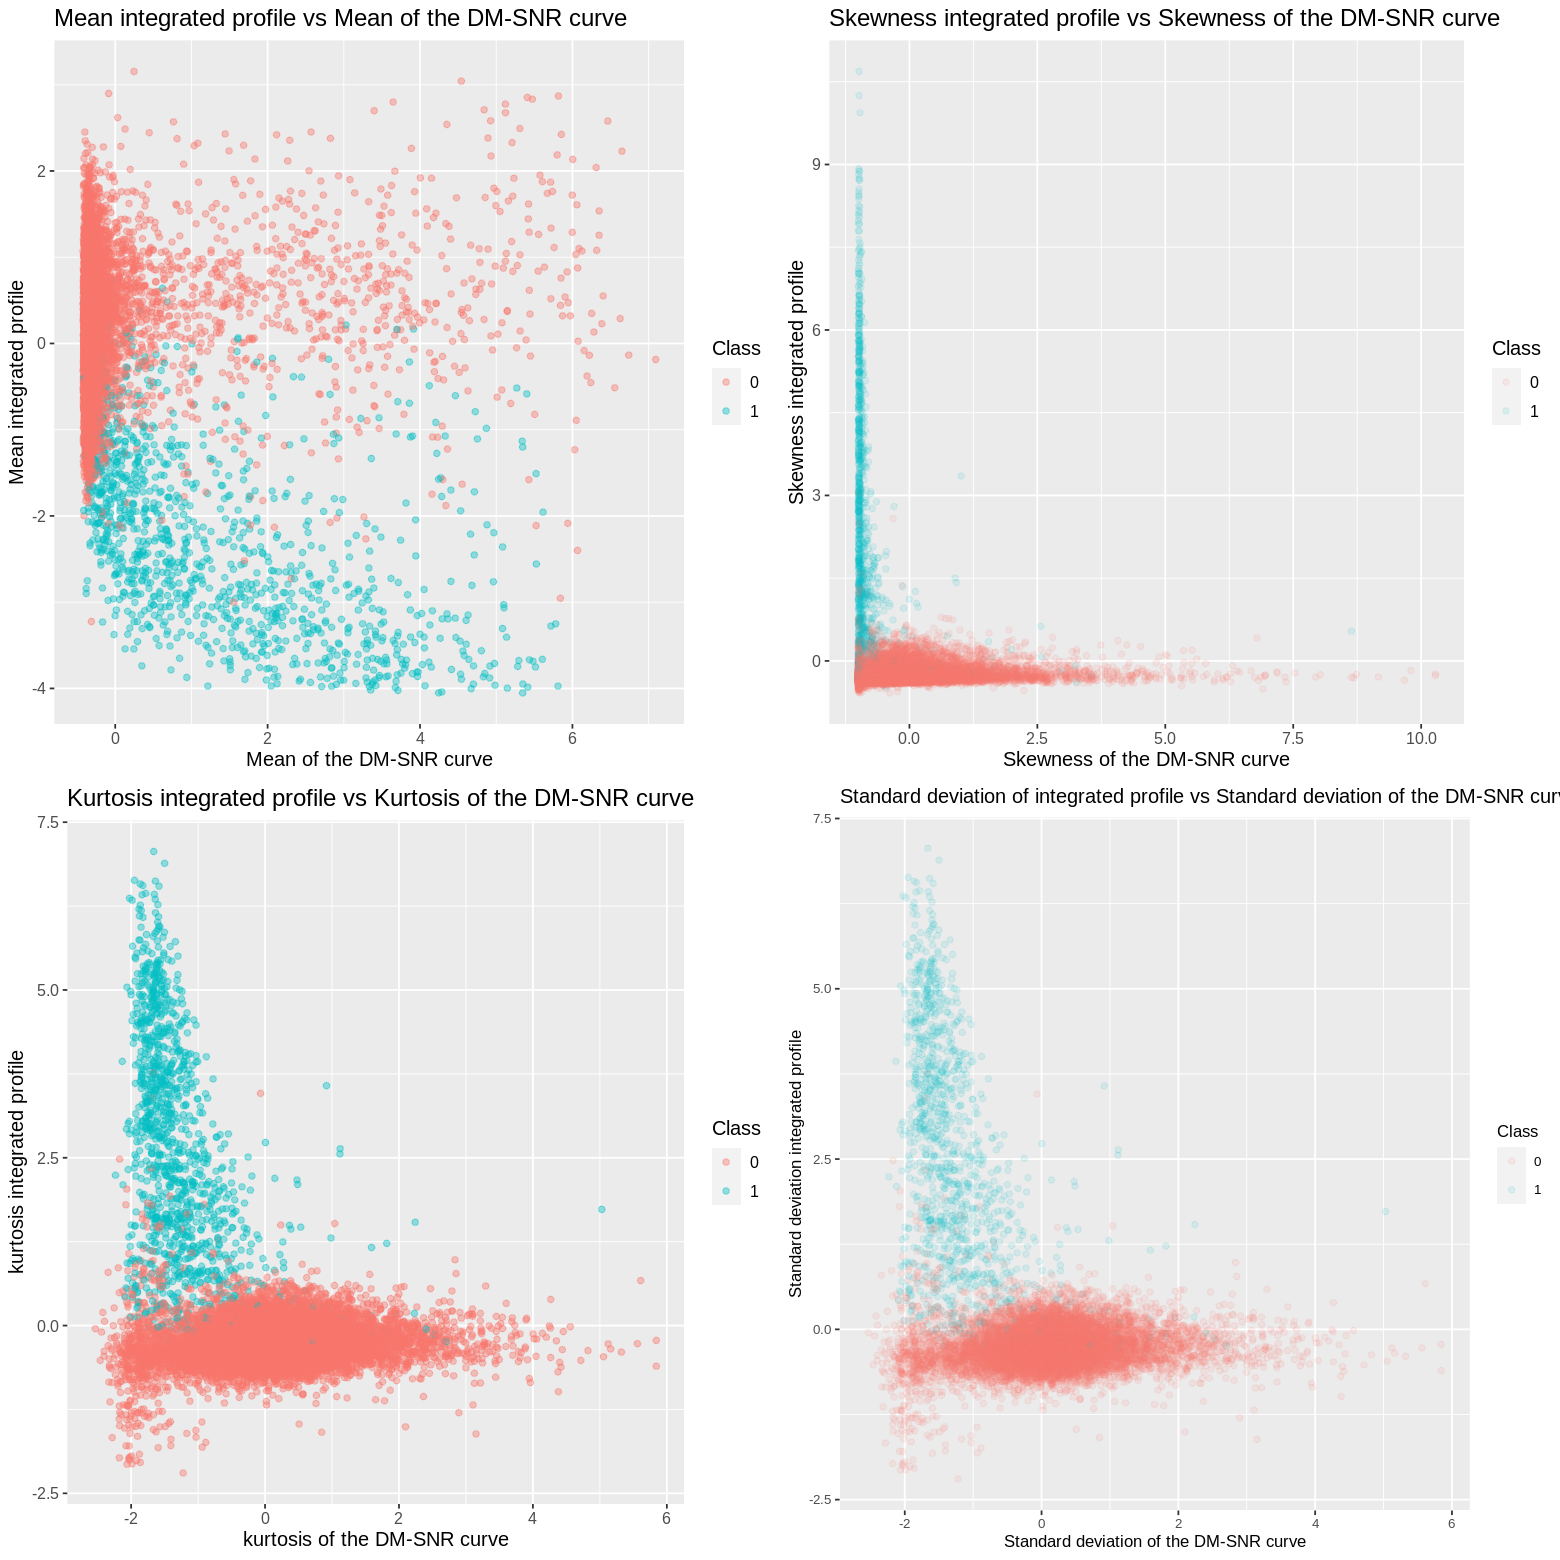

In [34]:
options(repr.plot.width = 13, repr.plot.height = 13)

plot_mean_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = mean_dm_snr, y =mean_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "Mean of the DM-SNR curve", y = "Mean integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Mean integrated profile vs Mean of the DM-SNR curve") 

plot_skew_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = skew_dm_snr, y= skew_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Skewness of the DM-SNR curve", y = "Skewness integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Skewness integrated profile vs Skewness of the DM-SNR curve") 

plot_kurt_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.4) +
                labs(x = "kurtosis of the DM-SNR curve", y = "kurtosis integrated profile", color = "Class") +
                theme(text = element_text(size = 12)) +
                ggtitle("Kurtosis integrated profile vs Kurtosis of the DM-SNR curve") 

plot_std_ip_dmsnr <- ggplot(pulsar_train_scaled, aes(x = kurt_dm_snr, y= kurt_ip , color = class)) +
                geom_point(alpha = 0.1) +
                labs(x = "Standard deviation of the DM-SNR curve", y = "Standard deviation integrated profile", color = "Class") +
                theme(text = element_text(size = 10)) +
                ggtitle("Standard deviation of integrated profile vs Standard deviation of the DM-SNR curve") 

plot_grid(plot_mean_ip_dmsnr, plot_skew_ip_dmsnr, plot_kurt_ip_dmsnr, plot_std_ip_dmsnr, ncol = 2, nrow = 2)

## Methods

We first loaded the dataset and added column names, and changed class into a fct instead of a dbl since this is the binary variable that we are trying to predict for. All of the 8 continuous variables will be used and we will visualize the relationships using scatterplots. The points will be coloured according to its class. Each scatterplot will have an x-axis with DM-SNR (either mean, standard, deviation, excess kurtosis, or skewness) and a y-axis with integrated profile. We will use the K-nearest neighbor classification and cross-validation to determine the k that we will use, we intend to use 5 folds to tune the model and maximize the accuracy of our model, this process will be done with all eight continuous variables mentioned above. 


## Expected Outcomes and Significance

#### What do you expect to find?
Based on the initial plots that we have above, kurtosis and skewness seem to have the same pattern and division of class 0 and 1 stars, this indicates to us that using these two as the predictor variables could be reliable. Class 0 and class 1 are also each individually concentrated within a range. 
However, the other two variables, mean and skewness are a bit more scattered and the relationship is harder to distinguish. 
#### What impact could such findings have?
Quick identification of pulsar star candidates helping in the study of the extreme states of matter, exploration of planets beyond the solar system, in the measurement of distances in space, and potentially even in the study of blackholes.
#### What future questions could this lead to?
- Why do pulsar stars have those predictor variable characteristics?
- Are there any thresholds for each continuous variable that determine if a star is potentially pulsar or not?
